In [3]:
!pip install -r requirements.txt

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib
import re
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from gensim.models import Phrases
from nltk.corpus import stopwords as nltk_stopwords
import spacy
import pickle
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords



In [2]:
# Download ntlk packages
import nltk
nltk.download('stopwords') # NLTK Stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

# Stopwords
nlp = spacy.load('en_core_web_sm') # loads spacy package
spacy_stopwords = set(nlp.Defaults.stop_words)
nltk_stopwords_set = set(nltk_stopwords.words('english'))
gensim_stopwords_set = set(gensim_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Load the dataset
data = pd.read_csv('twitter_dataset.csv', header=None, names=['sentiment', 'id', 'timestamp', 'query', 'user', 'text'], encoding='ISO-8859-1') # since utf - 8 is throwing error
data.head()

,sentiment,id,timestamp,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# Checking for missing data
data.isnull().sum()

sentiment    0
id           0
timestamp    0
query        0
user         0
text         0
dtype: int64

In [6]:
# Drop unnecessary columns
data = data.drop(['id', 'timestamp','query', 'user'], axis=1)


# Cleaning the dataset
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = text.replace('amp', '')  # Remove 'amp'
    text = text.replace('twitter', '')  # Remove 'twitter'
    return text

# Apply text cleaning
data['text'] = data['text'].apply(clean_text)
data.head()
# In sentiment, 0 for negative tweets and 4 for positive tweets are there

,sentiment,text
0,0,awww thats a bummer you shoulda got david ...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sa...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i he...


In [ ]:
# Checking the shape of the dataset
print("Shape of the dataset:", data.shape)

Shape of the dataset: (1600000, 2)


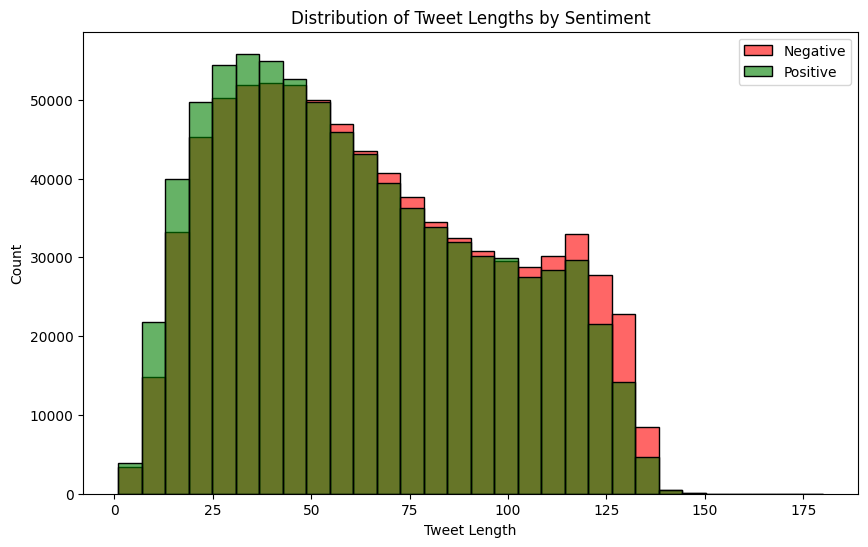

In [ ]:
# Creating a new column called "text_length"
data['text_length'] = data['text'].apply(len)

# Plotting the distribution of tweet lengths for each sentiment
plt.figure(figsize=(10, 6))
sns.histplot(data[data['sentiment'] == 0]['text_length'], bins=30, color='red', label='Negative', alpha=0.6)
sns.histplot(data[data['sentiment'] == 4]['text_length'], bins=30, color='green', label='Positive', alpha=0.6)
plt.legend()
plt.title('Distribution of Tweet Lengths by Sentiment')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.show()

# From this, we can see that negative tweets have more texts compared to positive tweets

In [ ]:
# Lemmatization and stopword removal
lemmatizer = WordNetLemmatizer()
stop_words = set(nltk_stopwords.words('english'))

# Additional stopwords or custom words to remove
additional_stopwords = set([
    'im', 'go', 'get', 'day', 'u', 'got', 'see', 'one', 'know', 'new', 'watch', 'want', 'back', 'realli'
])

# Merging stopword sets
combined_stopwords = nltk_stopwords_set.union(spacy_stopwords).union(gensim_stopwords_set).union(additional_stopwords)


In [ ]:

# Tokenization and preprocessing function
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())  # Tokenization and lowercasing
    tokens = [word for word in tokens if word.isalpha() and word not in combined_stopwords]  # Remove non-alphabetic tokens and stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return tokens

# Apply the preprocessing to the text data
data['tokens'] = data['text'].apply(preprocess_text)


In [ ]:

# Build bigrams and trigrams
bigram = Phrases(data['tokens'], min_count=5, threshold=100)
trigram = Phrases(bigram[data['tokens']], threshold=100)

# Apply bigrams and trigrams
data['tokens'] = data['tokens'].apply(lambda tokens: trigram[bigram[tokens]])

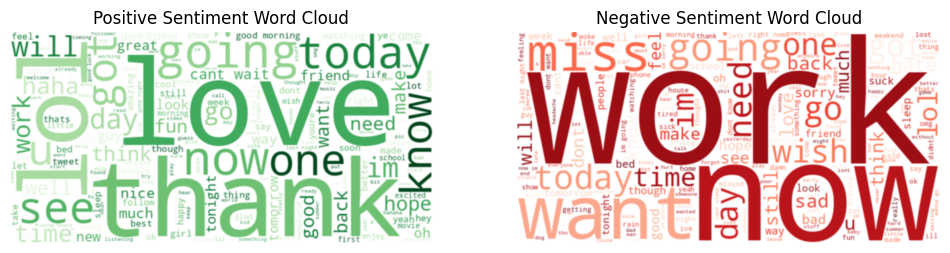

In [ ]:
# Joining all text data for positive and negative sentiments
positive_text = ' '.join(data[data['sentiment'] == 4]['text'])
negative_text = ' '.join(data[data['sentiment'] == 0]['text'])

# Generating word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap="Greens").generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bicubic')
plt.axis('off')
plt.title('Positive Sentiment Word Cloud')

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap="Reds").generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bicubic')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud')

plt.show()

# Work seems to the most stressing thing, huh


In [ ]:
# Use 'tokens' for positive and negative sentiments
positive_tokens = [token for tweet in data[data['sentiment'] == 4]['tokens'] for token in tweet]
negative_tokens = [token for tweet in data[data['sentiment'] == 0]['tokens'] for token in tweet]


# Count word frequencies
positive_word_counts = Counter(positive_tokens)
negative_word_counts = Counter(negative_tokens)

# Display most common words
print("Most common words in positive reviews:\n", positive_word_counts.most_common(20))
print("Most common words in negative reviews:\n", negative_word_counts.most_common(20))


Most common words in positive reviews:
 [('good', 60929), ('love', 49544), ('like', 37952), ('thanks', 33926), ('lol', 33517), ('time', 33206), ('going', 30653), ('today', 29212), ('great', 24891), ('night', 23157), ('dont', 22017), ('haha', 20792), ('think', 20524), ('morning', 20267), ('happy', 20075), ('hope', 19006), ('fun', 18033), ('ill', 17606), ('thats', 17478), ('nice', 16628)]
Most common words in negative reviews:
 [('dont', 44927), ('like', 41152), ('today', 36900), ('going', 33451), ('miss', 31867), ('time', 30599), ('good', 28598), ('sad', 27133), ('feel', 25238), ('need', 25190), ('home', 23896), ('wish', 23391), ('think', 22978), ('lol', 21711), ('oh', 21585), ('bad', 21373), ('night', 20402), ('sorry', 20113), ('didnt', 19958), ('hate', 18918)]


In [ ]:
print(data.columns)

Index(['sentiment', 'text', 'tokens'], dtype='object')


In [ ]:
data.head()

,sentiment,text,tokens
0,0,awww thats a bummer you shoulda got david ...,"[awww, thats, bummer, shoulda, david, carr]"
1,0,is upset that he cant update his facebook by t...,"[upset, update, facebook, texting, result, sch..."
2,0,i dived many times for the ball managed to sa...,"[dived, time, ball, managed, save, rest, bound]"
3,0,my whole body feels itchy and like its on fire,"[body, feel, itchy, like]"
4,0,no its not behaving at all im mad why am i he...,"[behaving, mad]"


In [7]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['sentiment'], test_size=0.2, random_state=42)


In [8]:

# Building a pipeline for SVM with SGDClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('pca', PCA(n_components=100)),  # For dimensionality reduction
    ('svm', SGDClassifier(loss='hinge', random_state=42, n_jobs=-1, early_stopping=True, validation_fraction=0.1))
])

In [9]:
# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('pca', PCA(n_components=100)),
                ('svm',
                 SGDClassifier(early_stopping=True, n_jobs=-1,
                               random_state=42))])

In [10]:
# Making predictions on the test set
y_pred = pipeline.predict(X_test)

In [11]:
# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.703775
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.70    159494
           4       0.70      0.71      0.71    160506

    accuracy                           0.70    320000
   macro avg       0.70      0.70      0.70    320000
weighted avg       0.70      0.70      0.70    320000

Confusion Matrix:
 [[111170  48324]
 [ 46468 114038]]


In [ ]:
# Changing the pipeline with LinearSVC
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svm', LinearSVC(random_state=42))
])

In [ ]:
# Define the parameter grid to search over
param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],  # Different values for max_features
    'tfidf__ngram_range': [(1, 1), (1, 2)],       # Unigrams and bigrams
    'svm__C': [0.1, 1, 10],                       # Regularization parameter
    'svm__penalty': ['l2'],                       # Regularization type
    'svm__loss': ['hinge', 'squared_hinge']       # Loss function for LinearSVC
}
# Initialize the GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)


In [ ]:

# Fit GridSearchCV to your training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Score: {grid_search.best_score_}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Best Parameters: {'svm__C': 1, 'svm__loss': 'hinge', 'svm__penalty': 'l2', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Best Cross-validation Score: 0.8036124994724161


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [48]:
# Defining the pipeline with best parameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=59000, ngram_range=(1, 2))),
    ('svm', LinearSVC(C=1, loss='hinge', penalty='l2',class_weight='balanced'))
])

In [49]:
# Fitting the pipeline again to the training data
pipeline.fit(X_train, y_train)

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=59000, ngram_range=(1, 2))),
                ('svm', LinearSVC(C=1, class_weight='balanced', loss='hinge'))])

In [50]:
# Making predictions again on the test set
y_pred = pipeline.predict(X_test)

In [51]:
# Evaluating the new model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.818990625
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82    159494
           4       0.81      0.83      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

Confusion Matrix:
 [[128818  30676]
 [ 27247 133259]]


In [32]:
# Defining the base classifier with the best parameters
base_clf = LinearSVC(C=1, random_state=30,penalty='l2', loss='hinge', class_weight='balanced') # class_weight is set to balanced to remove the bias

# Creating the BaggingClassifier with the base classifier
bagging_clf = BaggingClassifier(estimator=base_clf, n_estimators=10, random_state=30, n_jobs=-1)

# Defining the pipeline with the best parameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=59000, ngram_range=(1, 2))), # for max_features, I used trial and error method to find the optimized one
    ('bagging', bagging_clf)
])

In [33]:
# Fitting the pipeline again to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=59000, ngram_range=(1, 2))),
                ('bagging',
                 BaggingClassifier(estimator=LinearSVC(C=1,
                                                       class_weight='balanced',
                                                       loss='hinge',
                                                       random_state=30),
                                   n_jobs=-1, random_state=30))])

In [34]:
# Making predictions again on the test set
y_pred = pipeline.predict(X_test)

In [35]:
# Evaluating the new model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.819071875
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82    159494
           4       0.82      0.82      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

Confusion Matrix:
 [[130152  29342]
 [ 28555 131951]]


In [18]:
test = pipeline.predict(["Hi everyone, I feel so great today. The weather is nice."])

# Mapping 0 to 'negative' and 4 to 'positive'
sentiment_map = {0: "negative", 4: "positive"}
predicted_sentiment = sentiment_map.get(test[0], "unknown")

print("Predicted Sentiment:", predicted_sentiment)

Predicted Sentiment: positive


In [21]:
test = pipeline.predict(["What a way to waste my time"])

# Mapping 0 to 'negative' and 4 to 'positive'
sentiment_map = {0: "negative", 4: "positive"}
predicted_sentiment = sentiment_map.get(test[0], "unknown")

print("Predicted Sentiment:", predicted_sentiment)

Predicted Sentiment: negative


In [23]:
with open('model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

print("Pipeline saved successfully!")

Pipeline saved successfully!
